In [1]:
# 라이브러리 설치
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install numpy
!pip install sklearn

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
ERROR: kobert 0.1.2 has requirement transformers>=4.8.1, but you'll have transformers 3.0.2 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.13.0
    Uninstalling transformers-4.13.0:
      Successfully uninstalled transformers-4.13.0


In [2]:
# 라이브러리 설치 2
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-k9_o8j7b
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-k9_o8j7b
  Using cached transformers-4.13.0-py3-none-any.whl (3.3 MB)
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13125 sha256=847b3f117c5af4a0447b90782f7e536d588ef528d1c555a48bd669587c2d48af
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgswjoop/wheels/bf/5f/74/81bf3a1332130eb6629ecf58876a8746b77021e7d7b0638e91
Successfully built kobert
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.8.1rc1
    Uninstalling tokenizers-0.8.1rc1:
      Successfully uninstalled tokenizers-0.8.1rc1
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling trans

# 임포트

In [3]:
# 라이브러리 임포트
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import pandas as pd
from sklearn import metrics

In [4]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# 데이터 전처리

앞 단계에서 레이블링을 마친 학습 데이터와,
koBert가 사용하는 !!!TSV:Tab Separated Value!!!이 필요함
  
학습 데이터를 tsv로 변환해서 두 파일을 모두 사용할것임

요약
1. 학습데이터.csv             letter_mulit_training.csv
2. 학습데이터를.tsv 필요       letter_multi_training.txt(tsv파일은 .txt로도 인식가능)

In [8]:
letter_data = pd.read_csv('letter_mulit_training.csv')

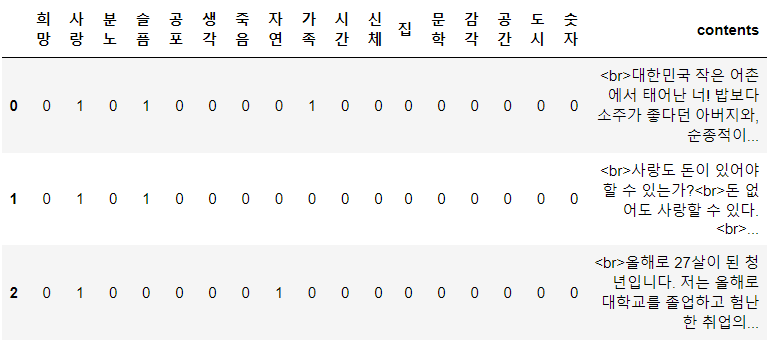

In [4]:
def text_clearing(text):
    text = text.replace("<br>", "")
    
    return text

letter_data['contents'] = letter_data['contents'].apply(text_clearing)

In [5]:
train_set = nlp.data.TSVDataset("letter_multi_training.txt", field_indices=[1,2])

# 데이터 셋 생성

In [6]:
# 순정 버트 모델, 보캡을 코버트에서 가져옴
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model
using cached model


In [7]:
MAX_LEN = 128          # 한 문장의 최대 크기
TRAIN_BATCH_SIZE = 1   # 한번 학습 시킬때 사용할 데이터의 크기(학습률에 관계없음, 작을수록 학습 시간이 더 오래걸림)
VALID_BATCH_SIZE = 16
EPOCHS = 10            # 학습을 반복할 횟수
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1     # 학습을 시작하기 전 하이퍼 파라미터의 값을 조정하기 위한 값

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False) #버트 토크나이저

device = torch.device("cuda") #CPU, GPU 

using cached model


In [10]:
target_cols = [col for col in letter_data.columns if col not in ['contents']]

target_cols = ['희망', '사랑', '분노', '슬픔', '공포', '생각', '죽음', '자연', '가족', '시간', '신체', '집', '문학', '감각', '공간', '도시', '숫자'])

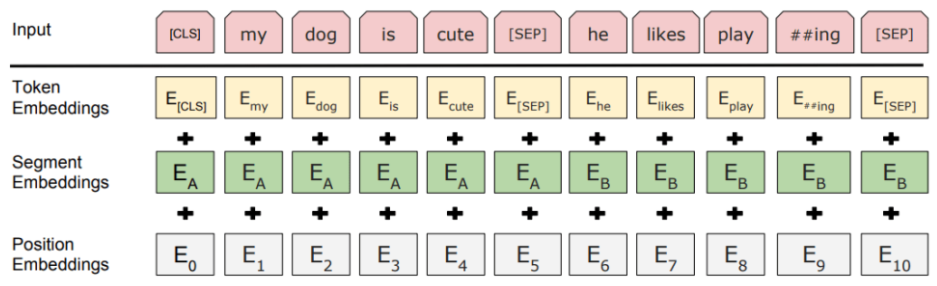  
버트모델이 사용하는 인풋 데이터는 총 세가지,  
1. 토큰 단위로 나뉘어진 문장, 문장의 시작을 표시하는 토큰 [CLS], 끝을 표시하는 토큰 [SEP]으로 감싸져있다  
각 토큰을 매칭되는 숫자 값으로 바꾼 데이터 EX) 아버지 -> 10  밑의 코드에서 'ids'  
각 토큰의 위치를 나타내는 데이터로 이루어짐  : 밑의 코드에서 'token_type_ids'  
2. 토큰과 실제 데이터를 식별하기 위한 마스크
[CLS],[SEP]등 식별 토큰과, 실제 문장의 토큰을 구별하기 위한 마스크 값,  
실제 데이터는 1로, 식별 토큰은 0으로 구분 : 밑의 코드에서 'mask'

In [10]:
class BERTDataset(Dataset):
    def __init__(self, df, label_df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.targets = label_df[target_cols].values

        transform = nlp.data.BERTSentenceTransform(tokenizer, max_seq_length = max_len,
                                               pad=True, pair=False)
        self.sentences = [transform([i[0]]) for i in df]
        
    def __len__(self):
        return len(self.df)
        
    #마스크 설정
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i in range(valid_length):
            attention_mask[i] = 1
        return attention_mask.float()

    def __getitem__(self, i):
        ids = torch.tensor(self.sentences[i][0], dtype=torch.long)
        valid_length = int(self.sentences[i][1])
        attention_mask = self.gen_attention_mask(ids, valid_length)
        
        return {
            'ids': ids,
            'mask': attention_mask,
            'token_type_ids' : torch.tensor(self.sentences[i][2], dtype=torch.long),
            'targets': torch.tensor(self.targets[i-1], dtype=torch.float)
        }
    
    #targets은 정답 레이블

In [11]:
train_dataset = BERTDataset(train_set, letter_data, tok, MAX_LEN)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4)

# 모델 생성 클래스

In [13]:
import transformers

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, # 히든 레이어 개수
                 num_classes=17, # 출력할 클래스 개수
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask, segment_ids):
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [14]:
model = BERTClassifier(bertmodel,  dr_rate=0.1).to(device)

In [15]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [16]:
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [17]:
t_total = len(train_loader) * EPOCHS
warmup_step = int(t_total * WARMUP_RATIO)

In [18]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [19]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 모델 학습

In [20]:
def train(epoch):
    model.train()
    for _, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [21]:
for epoch in range(EPOCHS):
    train(epoch)

  2%|▏         | 9/376 [00:00<00:07, 48.94it/s]

Epoch: 0, Loss:  5.912759780883789


  4%|▍         | 15/376 [00:00<00:04, 75.50it/s]

Epoch: 1, Loss:  5.726377964019775


  4%|▎         | 14/376 [00:00<00:04, 72.55it/s]

Epoch: 2, Loss:  5.710896015167236


  4%|▍         | 15/376 [00:00<00:04, 76.05it/s]

Epoch: 3, Loss:  5.863445281982422


  4%|▍         | 15/376 [00:00<00:04, 75.00it/s]

Epoch: 4, Loss:  5.843527793884277


  4%|▎         | 14/376 [00:00<00:04, 73.15it/s]

Epoch: 5, Loss:  5.771371364593506


  4%|▍         | 15/376 [00:00<00:04, 75.03it/s]

Epoch: 6, Loss:  5.700072288513184


  4%|▍         | 15/376 [00:00<00:04, 75.70it/s]

Epoch: 7, Loss:  5.736584663391113


  4%|▍         | 15/376 [00:00<00:04, 75.41it/s]

Epoch: 8, Loss:  5.804800987243652


  4%|▍         | 15/376 [00:00<00:04, 74.46it/s]

Epoch: 9, Loss:  5.571760654449463


100%|██████████| 376/376 [00:04<00:00, 89.14it/s]


# 모델 검사

In [22]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [23]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs,  normalize=False )
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

# accuracy가 높아야 좋음

Accuracy Score = 0
F1 Score (Micro) = 0.31677136874167144
F1 Score (Macro) = 0.20255532961909517
[[ True False  True ...  True False  True]
 [False  True  True ...  True False  True]
 [False  True  True ...  True False  True]
 ...
 [False False  True ...  True False  True]
 [False  True  True ...  True False  True]
 [False False  True ...  True False  True]]


# 모델 내보내기

In [28]:
MODEL_NAME = "model"
MODEL_SAVE_PATH = "./"+ MODEL_NAME


# torch.save(model, MODEL_SAVE_PATH) 모델을 통으로 내보내기
torch.save(model.state_dict(), MODEL_SAVE_PATH) # 모델 설정 정보만 내보내기

# 재학습

In [ ]:
"""
    한번 학습한 모델을 더 학습하면 좋은 결과 나올수도..
    
    편지 데이터로 학습한뒤 시데이터로 학습(같은 클래스로 분류되어 있기 때문),
    마지막으로 편지데이터 학습이 중요하기 때문에
    편지 데이터로 두 세번더 학습 시켜주면 좋다고함
"""

In [ ]:
# saved_model = torch.load(MODEL_SAVE_PATH) 모델을 통으로 내보냈을때

# 모델 설정 정보만 내보냈을때
saved_model, vocab = get_pytorch_kobert_model(cachedir=".cache") # 순정 버트 모델 가져옴
saved_model.load_state_dict(torch.load(MODEL_SAVE_PATH)) # 순정 모델에 가져온 정보 저장
saved_model = saved_model.cuda() #GPU

# GUP에서 내보낸 모델 CPU에서 받을때
# saved_model.load_state_dict(torch.load(MODEL_SAVE_PATH)), map_location=device)

In [ ]:
new_data = pd.read_csv('')  #새로 학습 시킬 데이터 입력

def text_clearing(text):
    text = text.replace("<br>", "")
    
    return text

new_data['contents'] = new_data['contents'].apply(text_clearing)

In [ ]:
train_set = nlp.data.TSVDataset("", field_indices=[1,2]) #새로 학습 시킬 데이터 입력

In [ ]:
saved_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 1
# VALID_BATCH_SIZE = 16
# EPOCHS = 10
# LEARNING_RATE = 2e-5
# WARMUP_RATIO = 0.1

In [ ]:
# 위에 train함수 써도 되는데 위로 올라가기 귀찮아서 복사해놓음
def train2(epoch):
    saved_model.train()
    for _, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = saved_model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train2(epoch)

In [ ]:
def validation2():
    model2.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model2(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation2()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

# 메모리 정리

In [ ]:
#용량이 없어서 학습이 안될때 한번씩 해주면 됨

import gc

gc.collect()
torch.cuda.empty_cache()

# 모델 사용

In [ ]:
def predict(predict_sentence):
    result_dataframe = pd.DataFrame(columns=target_cols)

    data = [predict_sentence]

    another_test = BERTDataset(data, letter_data, tok, MAX_LEN)
    test_dataloader = DataLoader(another_test, batch_size=TRAIN_BATCH_SIZE, num_workers=4)

    saved_model.eval() # 모델 변경 부분
    for _, data in enumerate(test_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = saved_model(ids, mask, token_type_ids)  # 모델 변경 부분
        
    result_dataframe.loc[0] = [i for i in outputs.tolist()[0]]
    print(result_dataframe)

In [ ]:
predict("엄마 뭐해 사랑해 행복해 내일보자")